In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [47]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (GRU, LSTM, RNN, Activation, Bidirectional,
                                     Dense, GRUCell, LSTMCell, TimeDistributed)
from tensorflow.keras.losses import MeanSquaredError as loss_mean_squared_error
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import set_random_seed

<IPython.core.display.Javascript object>

# Create data for univariate timeseries

In [3]:
data = np.array([i * 10.0 for i in range(1000)])

<IPython.core.display.Javascript object>

In [4]:
TRAIN_SIZE_RATIO = 0.75
train_size = np.floor(len(data) * TRAIN_SIZE_RATIO).astype(int)

X_train = data[:train_size]
X_test = data[train_size:]

<IPython.core.display.Javascript object>

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1))

<IPython.core.display.Javascript object>

In [6]:
LENGTH = 5  # Time steps

generator_train = TimeseriesGenerator(
    data=X_train_scaled,
    targets=X_train_scaled,
    length=LENGTH,
    batch_size=1,
    stride=1,
    shuffle=False,
)

<IPython.core.display.Javascript object>

In [7]:
generator_test = TimeseriesGenerator(
    data=X_test_scaled,
    targets=X_test_scaled,
    length=LENGTH,
    batch_size=1,
    stride=1,
    shuffle=False,
)

<IPython.core.display.Javascript object>

# Create model

In [34]:
set_random_seed(42)


model = tf.keras.models.Sequential(
    [
        Bidirectional(
            tf.keras.layers.LSTM(
                units=100,
                return_sequences=False,
            ),
            input_shape=(LENGTH, 1),
        ),
        tf.keras.layers.Dense(1, activation=None),
    ]
)


OPTIMIZER = Adam(learning_rate=0.01)
LOSS = loss_mean_squared_error()


model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=[MeanSquaredError(name="mse")],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [35]:
def train(X, **kwargs):
    history = model.fit(X, **kwargs)
    return history

<IPython.core.display.Javascript object>

In [36]:
history = train(
    generator_train,
    validation_data=generator_test,
    epochs=200,
    batch_size=1,
    callbacks=[
        EarlyStopping(mode="min", monitor="val_mse", patience=10),
        ReduceLROnPlateau(
            min_val=0.0, factor=0.1, mode="min", monitor="val_mse", patience=10
        ),
    ],
)

Epoch 1/200
745/745 [==============================] - 6s 4ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0012 - val_mse: 0.0012 - lr: 0.0100
Epoch 2/200
745/745 [==============================] - 2s 3ms/step - loss: 2.0426e-05 - mse: 2.0426e-05 - val_loss: 6.3150e-05 - val_mse: 6.3150e-05 - lr: 0.0100
Epoch 3/200
745/745 [==============================] - 2s 3ms/step - loss: 5.0948e-04 - mse: 5.0948e-04 - val_loss: 1.1243e-04 - val_mse: 1.1243e-04 - lr: 0.0100
Epoch 4/200
745/745 [==============================] - 2s 3ms/step - loss: 3.5078e-05 - mse: 3.5078e-05 - val_loss: 1.7955e-05 - val_mse: 1.7955e-05 - lr: 0.0100
Epoch 5/200
745/745 [==============================] - 2s 3ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.7414e-04 - val_mse: 7.7414e-04 - lr: 0.0100
Epoch 6/200
745/745 [==============================] - 2s 3ms/step - loss: 2.1276e-05 - mse: 2.1276e-05 - val_loss: 0.0012 - val_mse: 0.0012 - lr: 0.0100
Epoch 7/200
745/745 [==============================] - 2s 3m

<IPython.core.display.Javascript object>

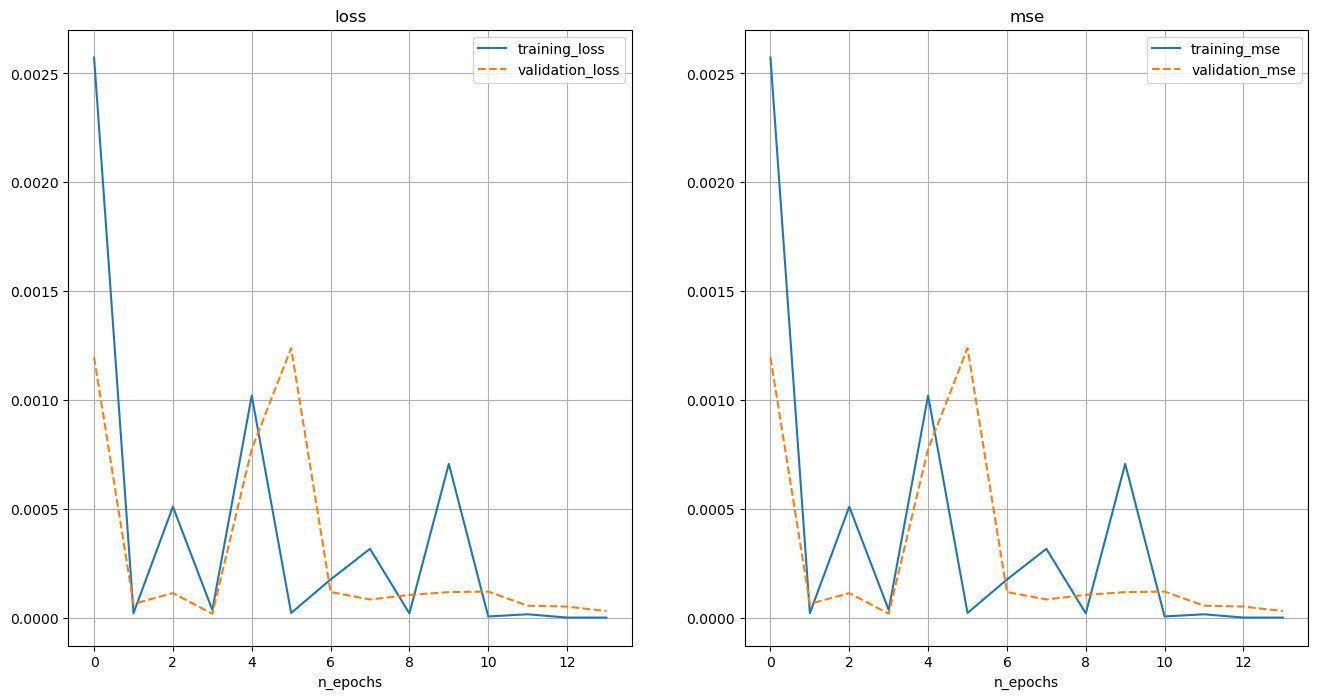

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for idx, label in enumerate(["loss", "mse"]):

    ax[idx].plot(history.history[f"{label}"], label=f"training_{label}")
    ax[idx].plot(
        history.history[f"val_{label}"], label=f"validation_{label}", linestyle="--"
    )
    ax[idx].set_title(f"{label}")
    ax[idx].legend()
    ax[idx].grid(True)

    ax[idx].set_xlabel("n_epochs")

In [42]:
data_to_predict = np.array([0, 10, 20, 30, 40]) + 30
data_to_predict_scaled = scaler.transform(data_to_predict.reshape(-1, 1))
data_to_predict_scaled_reshaped = data_to_predict_scaled.reshape(1, LENGTH, 1)

y_pred = model.predict(data_to_predict_scaled_reshaped)
scaler.inverse_transform(y_pred)

1/1 [==============================] - 0s 15ms/step


array([[75.54213]], dtype=float32)

<IPython.core.display.Javascript object>

In [43]:
X_test_scaled_reshaped = X_test_scaled.reshape(1, X_test_scaled.shape[0], 1)
y_pred = model.predict(generator_test)
y_pred_inverse_transformed = scaler.inverse_transform(y_pred)

245/245 [==============================] - 1s 922us/step


<IPython.core.display.Javascript object>

# Plot predictions

In [44]:
# We need to take the predictions for the last LENGTH sequences and append them.



def get_last_n_predictions(
    x: np.array, model, n: int, debug: bool = True
) -> List[np.array]:
    first_eval_batch = x[-n:]
    current_batch = first_eval_batch.reshape((1, n, 1))

    test_predictions = []
    for _ in range(n):
        if debug:
            print(current_batch)
        current_pred = model.predict(current_batch, verbose=0)
        if debug:
            print("prediction:", current_pred)
            print("\n")
        test_predictions.append(current_pred[0])
        current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)
    return np.array(test_predictions)


last_n_predictions = get_last_n_predictions(X_test_scaled, model, LENGTH, debug=True)

last_n_predictions_inverse_transformed = scaler.inverse_transform(last_n_predictions)
y_pred_inverse_transformed = np.append(
    y_pred_inverse_transformed[:, 0], last_n_predictions_inverse_transformed
)

y_pred_inverse_transformed

[[[1.32843792]
  [1.32977303]
  [1.33110814]
  [1.33244326]
  [1.33377837]]]
prediction: [[1.323927]]


[[[1.32977303]
  [1.33110814]
  [1.33244326]
  [1.33377837]
  [1.32392704]]]
prediction: [[1.3186584]]


[[[1.33110814]
  [1.33244326]
  [1.33377837]
  [1.32392704]
  [1.31865835]]]
prediction: [[1.3185508]]


[[[1.33244326]
  [1.33377837]
  [1.32392704]
  [1.31865835]
  [1.31855083]]]
prediction: [[1.3170761]]


[[[1.33377837]
  [1.32392704]
  [1.31865835]
  [1.31855083]
  [1.31707609]]]
prediction: [[1.3172765]]




array([7548.0986, 7557.9614, 7567.8257, 7577.6875, 7587.549 , 7597.4077,
       7607.267 , 7617.1216, 7626.979 , 7636.831 , 7646.6855, 7656.5386,
       7666.3887, 7676.2373, 7686.084 , 7695.9326, 7705.7773, 7715.621 ,
       7725.4634, 7735.3047, 7745.144 , 7754.981 , 7764.82  , 7774.656 ,
       7784.4897, 7794.3267, 7804.1543, 7813.9844, 7823.814 , 7833.6416,
       7843.4663, 7853.294 , 7863.113 , 7872.9375, 7882.7563, 7892.574 ,
       7902.3896, 7912.2095, 7922.0225, 7931.8394, 7941.647 , 7951.459 ,
       7961.267 , 7971.077 , 7980.883 , 7990.6855, 8000.4883, 8010.2925,
       8020.088 , 8029.889 , 8039.685 , 8049.48  , 8059.2744, 8069.0703,
       8078.861 , 8088.6504, 8098.436 , 8108.224 , 8118.01  , 8127.7915,
       8137.5713, 8147.3545, 8157.1357, 8166.912 , 8176.686 , 8186.4634,
       8196.235 , 8206.005 , 8215.774 , 8225.544 , 8235.309 , 8245.071 ,
       8254.835 , 8264.6   , 8274.356 , 8284.116 , 8293.874 , 8303.628 ,
       8313.385 , 8323.135 , 8332.887 , 8342.635 , 

<IPython.core.display.Javascript object>

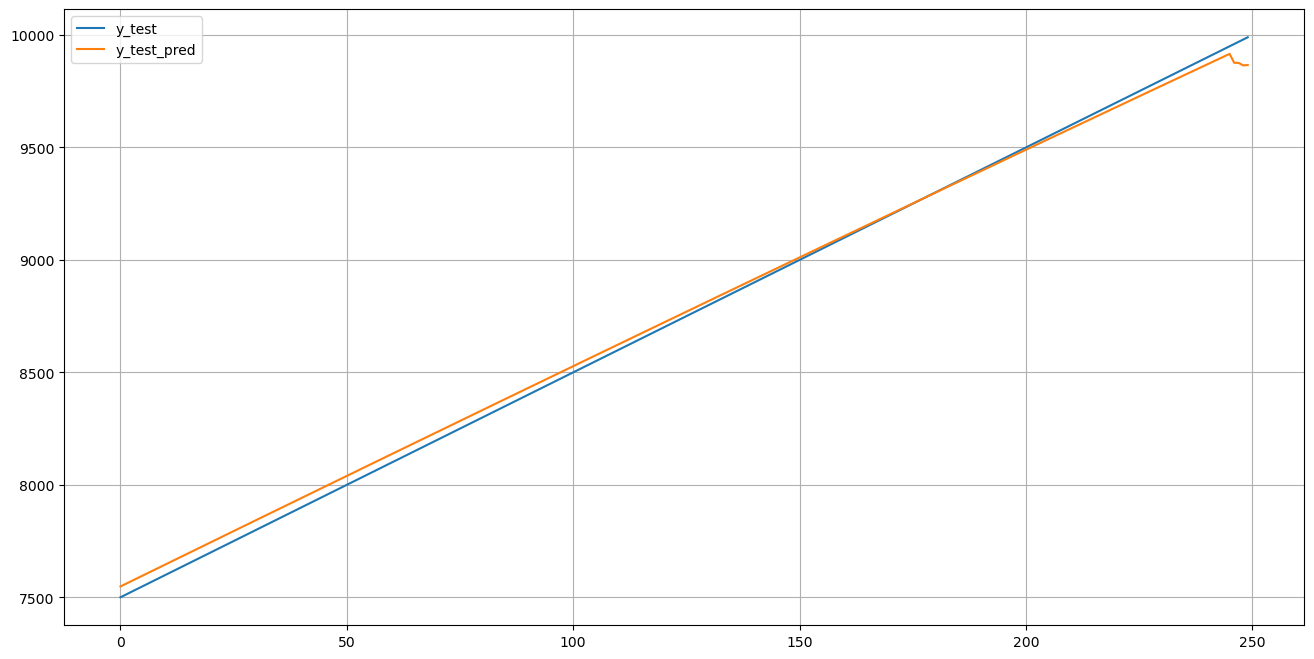

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(range(len(X_test)), X_test, label="y_test")
ax.plot(range(len(X_test)), y_pred_inverse_transformed, label="y_test_pred")
ax.legend()

ax.grid(True)